# Learning to Take a Break
## Environment setup

General imports:

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['text.usetex'] = True
%config InlineBackend.figure_format = 'retina'

import scipy.interpolate

import lvml
from lvml.experiment.analysis import *

RANDOM_STATE = 0
lvml.random_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)


## Characteristic behavior

Init LV simulator:

In [2]:
schematic_lv = lvml.LotkaVolterraDynamicalSystem(
    alpha=1,
    beta=[2.1]*5,
    gamma=1e-1,
    delta=1e-2,
)

myopic_recommender = lvml.StationaryRecommender(
    p_fb=0,
    predicted_ratings=[1],
    true_ratings=[1],
    softmax_t=1,
)

schematic_ivp = lvml.IVP(
    y_0=[6,0.75],
    T=100,
)

Simulate ODE:

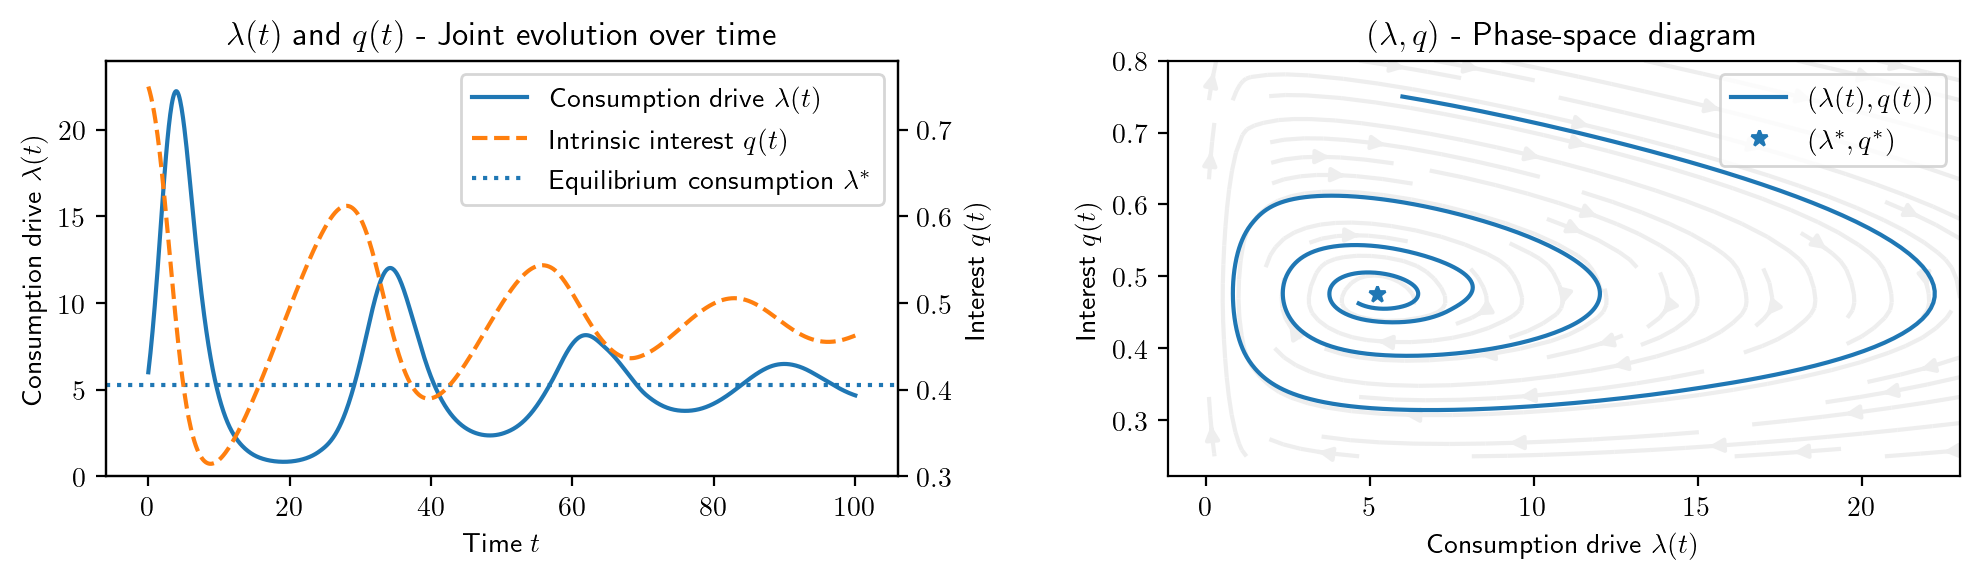

In [3]:
res = schematic_lv.simulate_ode(schematic_ivp, myopic_recommender, num_steps=1000)
    
fig,axs = create_fig(1,2)

def plot_time_evolution(ax, frame=None):
    ax.clear()
    ax.plot(res.t[:frame], res.y[0][:frame], label=f'Consumption drive $\lambda(t)$', color='tab:blue')
    ax.set_ylim([0,24])
    ax.set_xlim([-6,106])
    ax0_twinx = ax.twinx()
    ax0_twinx.clear()
    ax0_twinx.plot(res.t[:frame], res.y[1][:frame], label=f'Intrinsic interest $q(t)$', color='tab:orange', linestyle='--', zorder=-1)
    ax0_twinx.set_ylim([0.3,0.78])

    ax.axhline(
        myopic_recommender.equilibrium(schematic_lv)[0],
        color='tab:blue',
        linestyle=':',
        label=r'Equilibrium consumption $\lambda^*$',
        zorder=-2
    )

    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax0_twinx.get_legend_handles_labels()
    ax.legend(
        lines[:1] + lines2 + lines[1:],
        labels[:1] + labels2 + labels[1:],
        loc='upper right',
    )

    ax.set(
        xlabel='Time $t$',
        ylabel=r'Consumption drive $\lambda(t)$',
        title=r'$\lambda(t)$ and $q(t)$ - Joint evolution over time',
    )
    ax0_twinx.set_ylabel(r'Interest $q(t)$')
    return ax,ax0_twinx
    

def plot_phase_space(ax, frame=None):
    ax.clear()
    ax.plot(res.y[0][:frame], res.y[1][:frame], label=r'$(\lambda(t),q(t))$', color='tab:blue')
    ax.set(
        xlabel=r'Consumption drive $\lambda(t)$',
        ylabel=r'Interest $q(t)$',
        title=r'$(\lambda,q)$ - Phase-space diagram',
    )

    n,q = np.meshgrid(
        np.linspace(0.1,23,20),
        np.linspace(0.25,0.8,15),
    )

    u = 1
    v = -1

    nq=np.stack([n,q],axis=0)

    lv_A = np.zeros((2,2))
    lv_A[0,1] = schematic_lv.beta[0]
    lv_A[1,0] = -schematic_lv.delta
    lv_A[1,1] = -schematic_lv.gamma
    lv_r = np.zeros(2)
    lv_r[0] = -schematic_lv.alpha
    lv_r[1] = schematic_lv.gamma

    uv = nq*(np.einsum('ij,jkl',lv_A, nq) + np.expand_dims(np.expand_dims(lv_r, axis=-1), axis=-1))
    u,v = uv/np.linalg.norm(uv,axis=0)

    ax.streamplot(n,q,u,v, density=0.7, arrowsize=1, color='#EEE', zorder=-1)
    ax.plot(
        myopic_recommender.equilibrium(schematic_lv)[0],
        myopic_recommender.equilibrium(schematic_lv)[1],
        '*',
        color='tab:blue',
        label=r'$(\lambda^*, q^*)$',
    )
    ax.legend(
        loc='upper right',
    )
    return ax
    
plot_time_evolution(axs[0])
plot_phase_space(axs[1])
fig.download('schematic_lv_diagram.pdf')

Presentation animation

In [4]:
# import os
# from tqdm.auto import tqdm
# os.mkdir('./output/animation/1')
# os.mkdir('./output/animation/2')
# for frame in tqdm(range(2,1200,5)):
#     fig,ax = create_fig(figsize=(12,4))
#     plot_time_evolution(ax,frame)[0].set_title('')
#     fig.savefig(f'./output/animation/1/out_{frame:05}.png', dpi=200)
#     plt.close()
#     fig,axs = create_fig(1,2,figsize=(10,4))
#     plot_time_evolution(axs[0],frame)
#     plot_phase_space(axs[1],frame)
#     fig.savefig(f'./output/animation/2/out_{frame:05}.png', dpi=200)
#     plt.close()

## Bash: for i in {1..2}; do echo $i; ffmpeg -framerate 24 -pattern_type glob -i "./$i/*.png" -c:v libx264 -pix_fmt yuv420p out_$i.mp4; done


## Supporting figures for proofs

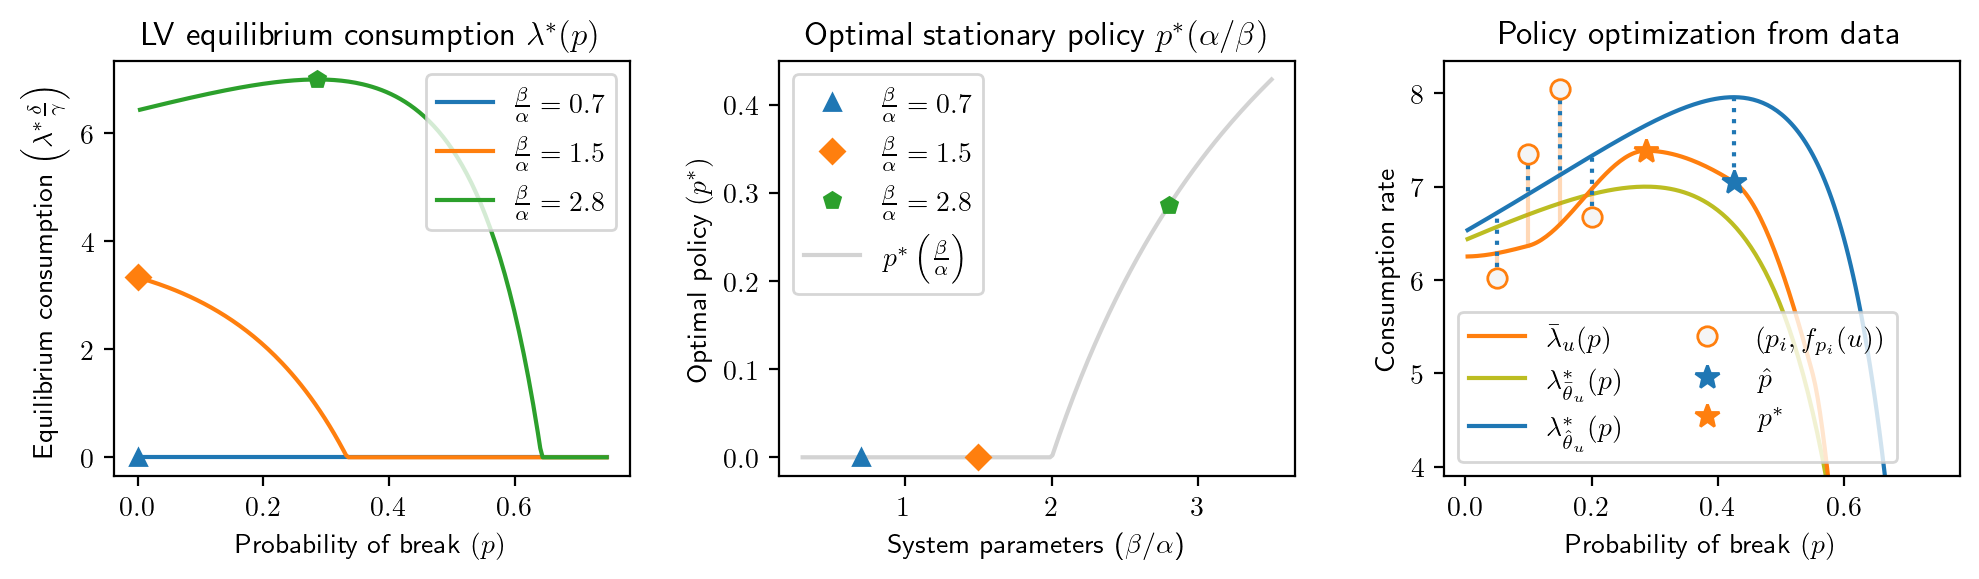

In [5]:
# lv_eq = lambda r,p: np.clip((1/(1-p))*(1-r/(1-p)), a_min=0, a_max=None)

# p = np.linspace(0,1,200)[1:-1]
p_vec = np.linspace(0,0.75,200)[1:-1]

fig,axs = create_fig(1,3,tight_layout={'w_pad':2})

markers = ['^','D','p']

ab_vals = [1/0.7, 1/1.5, 1/2.8]
gd = schematic_lv.gamma/schematic_lv.delta

def plot_equilibrium_curve(ax, show_marker=True):
    for (ab,c,m) in zip(ab_vals,matplotlib.colors.TABLEAU_COLORS,markers):
        if 1/ab<=2:
            if 1/ab<=1:
                regime = 'Churn regime'
            else:
                regime = 'Myopic regime'
        else:
            regime = 'Breaks are beneficial'
        # Equilibrium curve
        ax.plot(
            p_vec,
            lv_eq_f(ab,gd,p_vec),
            color=c,
            label=r'$\frac{\beta}{\alpha}=%.1f$' % (1/ab),
        )
        # Optimal policy
        if show_marker:
            ax.plot(
                p_opt_f(ab),
                opt_eq_f(ab, gd),
                linestyle='',
                marker=m,
                color=c,
            )
    ax.set(
        xlabel=r'Probability of break $\left(p\right)$',
        ylabel=r'Equilibrium consumption $\left(\lambda^* \frac{\delta}{\gamma}\right)$',
        title=r'LV equilibrium consumption $\lambda^*(p)$',
    )
    ax.legend(loc='upper right')
    return ax

plot_equilibrium_curve(axs[0])
    
#####

for (ab,c,m) in zip(ab_vals,matplotlib.colors.TABLEAU_COLORS,markers):
    axs[1].plot(
        1/ab,
        p_opt_f(ab),
        linestyle='',
        marker=m,
        color=c,
        label=r'$\frac{\beta}{\alpha}=%.1f$' % (1/ab),
    )

b_vec = np.linspace(0.3,3.5,200)
ab_vec = 1/b_vec
axs[1].plot(
    b_vec,
    p_opt_f(ab_vec),
    '-',
    color='lightgrey',
    zorder=-1,
    label=r'$p^*\left(\frac{\beta}{\alpha}\right)$',
)
axs[1].set(
    xlabel=r'System parameters ($\beta/\alpha$)',
    ylabel=r'Optimal policy $\left(p^*\right)$',
    title=r'Optimal stationary policy $p^*(\alpha/\beta)$',
)
axs[1].legend()

####

ax=axs[2]
ab = 1/2.8

true_c = 'tab:orange'
fit_c = 'tab:olive'
est_c = 'tab:blue'

data_points = {
    p: lv_eq_f(ab,gd,p)*(1+skew)
    for p,skew in zip(
        [0.05, 0.1, 0.15, 0.2],
        (np.array([-0.12, 0.03, 0.1, -0.08])+0.05)*1.2,
    )
}


oracle_params = (ab,gd)
est_params = (
    lvml.LotkaVolterraOptimalForcedBreaksPolicy
    .lv_params_from_predictions(data_points)
)

rng = np.random.default_rng(seed=RANDOM_STATE)
interp_points = np.hstack([
    [0.0,0.1,0.55,0.65, 0.8,0.99],
    [p_opt_f(est_params[0]), p_opt_f(ab)],
])
argsort = np.argsort(interp_points)
interp_skew = rng.normal(loc=-4e-2, scale=1e-1,size=len(interp_points))
interp_skew[-1] = 0.055
interp_skew[-2] = 0.07
interp_skew[1] = -0.05
interp_skew[2] = 0.09
interp_skew[3] = 0.2
interp_curve = scipy.interpolate.pchip_interpolate(
    xi=interp_points[argsort],
    yi=(lv_eq_f(ab,gd,interp_points)*(1+interp_skew)).clip(min=0)[argsort],
    x=p_vec
)
ax.plot(p_vec, interp_curve, color=true_c, label=r'$\bar{\lambda}_u(p)$')
interp_f = scipy.interpolate.interp1d(
    x=p_vec,
    y=interp_curve,
)


for p in data_points:
    ax.plot(
        [p,p],
        [interp_f(p), data_points[p]],
        color=true_c,
        alpha=0.3,
    )
    ax.plot(
        [p,p],
        [data_points[p], lv_eq_f(*est_params,p_fb=p)],
        color=est_c,
        linestyle=':'
    )

ax.plot(
    p_vec,
    lv_eq_f(*oracle_params,p_fb=p_vec),
    color=fit_c,
    linestyle='-',
    label=r'$\lambda^*_{\bar{\theta}_u}(p)$',
    zorder=-1,
)

ax.plot(
    p_vec,
    lv_eq_f(*est_params,p_fb=p_vec),
    color=est_c,
    label=r'$\lambda^*_{\hat{\theta}_u}(p)$'
)

ax.plot(
    *np.array(list(data_points.items())).T,
    'o',
    color='whitesmoke',
    markersize=7,
    markeredgecolor=true_c,
    label=r'$\left(p_i, f_{p_i}(u)\right)$'
)

p_fb_opt_est = p_opt_f(est_params[0])
ax.plot(
    [p_fb_opt_est]*2,
    [
        lv_eq_f(*est_params,p_fb=p_fb_opt_est),
        interp_f(p_fb_opt_est),
    ],
    ':',
    color=est_c,
)

ax.plot(
    p_fb_opt_est,
    interp_f(p_fb_opt_est),
    '*',
    color=est_c,
    markersize=9,
    label=r'$\hat{p}$'
)

p_fb_opt_oracle = p_opt_f(oracle_params[0])
ax.plot(
    p_fb_opt_oracle,
    interp_f(p_fb_opt_oracle),
    '*',
    color=true_c,
    markersize=9,
    label=r'$p^*$'
)

ax.set(ylim=[3.9,8.35])

ax.legend(ncol=2)
ax.set(
    title=f'Policy optimization from data',
    xlabel=r'Probability of break $\left(p\right)$',
    ylabel='Consumption rate',
)

fig.download('schematic_equilibrium_analysis.pdf')

<AxesSubplot:title={'center':'LV equilibrium consumption $\\lambda^*(p)$'}, xlabel='Probability of break $\\left(p\\right)$', ylabel='Equilibrium consumption $\\left(\\lambda^* \\frac{\\delta}{\\gamma}\\right)$'>

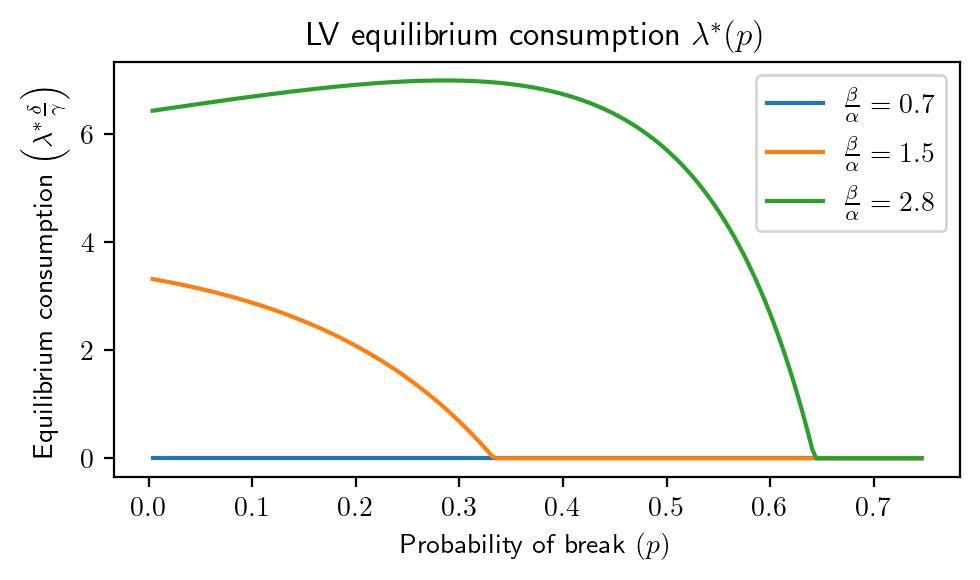

In [6]:
fig,ax = create_fig(figsize=(5,3))
plot_equilibrium_curve(ax, False)

<AxesSubplot:title={'center':'LV equilibrium consumption $\\lambda^*(p)$'}, xlabel='Probability of break $\\left(p\\right)$', ylabel='Equilibrium consumption $\\left(\\lambda^* \\frac{\\delta}{\\gamma}\\right)$'>

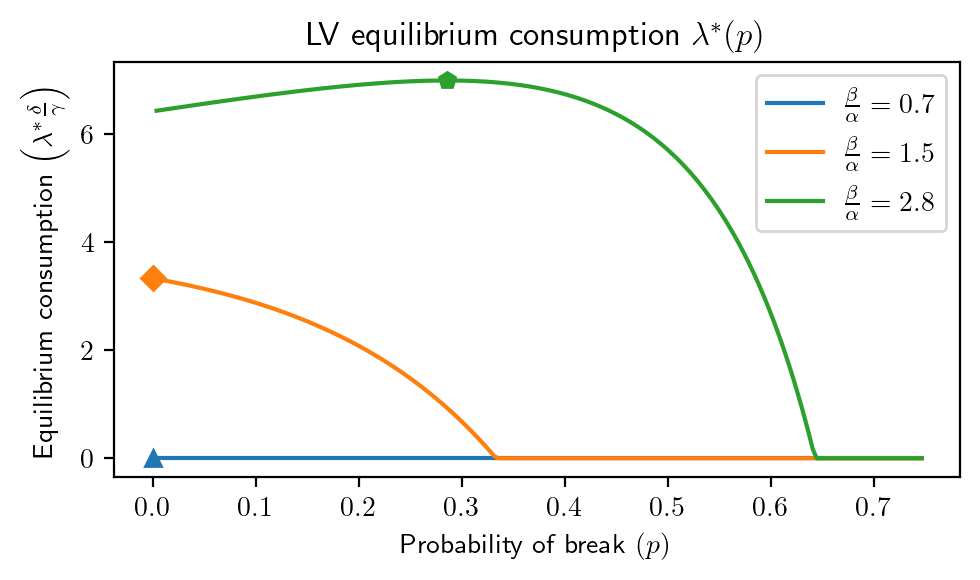

In [7]:
fig,ax = create_fig(figsize=(5,3))
plot_equilibrium_curve(ax)

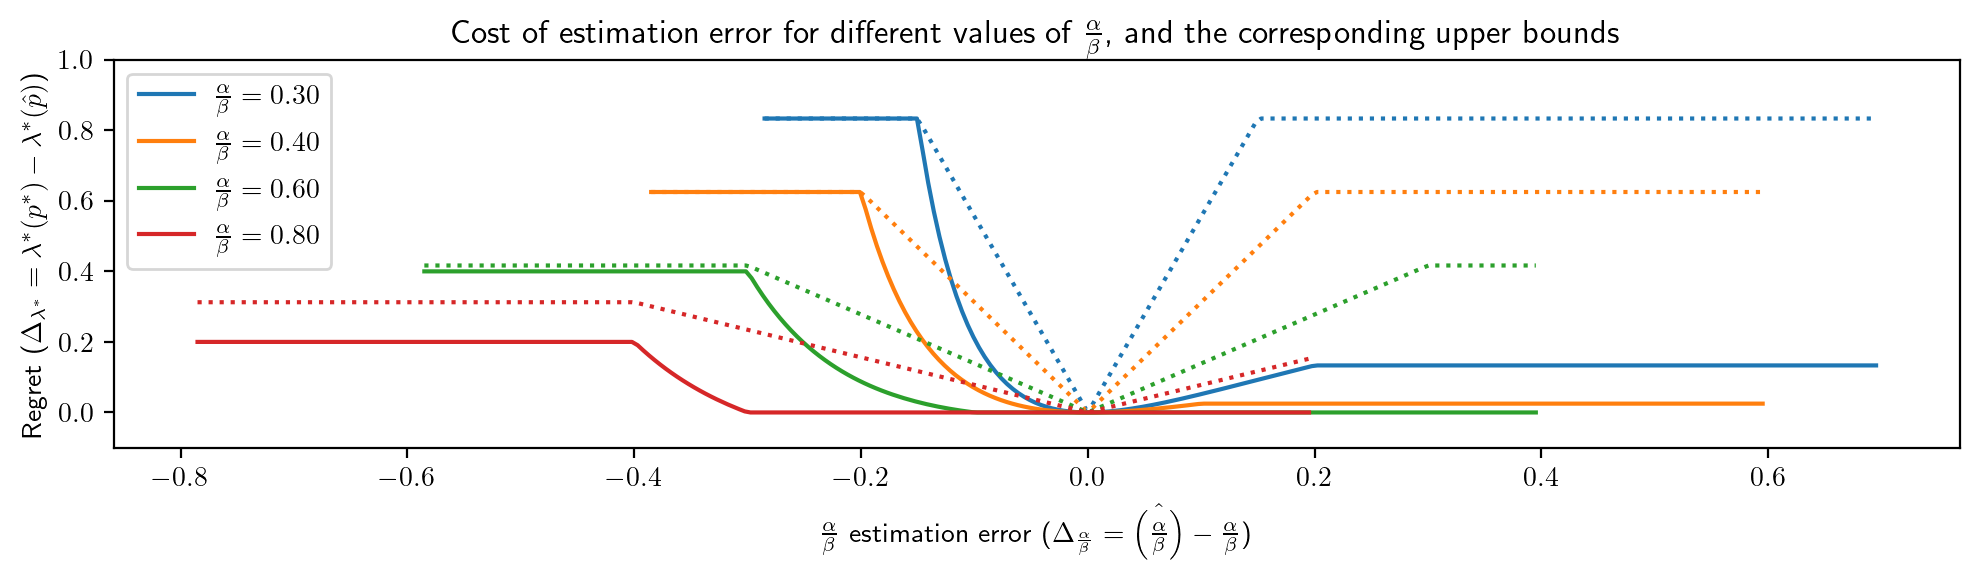

In [8]:
r_hat = np.linspace(0.01,1,200)[1:-1]
fig,ax = create_fig()

for r in [0.3, 0.4, 0.6, 0.8]:
    true_opt = (1/(4*r))*(r<=0.5) + (1-r)*(r*0+1)*(r>0.5) 
    est_opt = np.clip(
        (1/(2*r_hat))*(1-r/(2*r_hat))*(r_hat<=0.5) + (1-r)*(r_hat*0+1)*(r_hat>0.5),
        a_min=0,
        a_max=None,
    )
    eps = r_hat-r
    line = ax.plot(eps, true_opt-est_opt, label=r'$\frac{\alpha}{\beta}=%.2f$' % r)
    c = line[0].get_color()
    ax.plot(eps, np.clip((1/(2*r**2))*np.abs(eps), a_min=None, a_max=1/(4*r)), ':', color=c)
    
ax.legend()
ax.set(
    ylim=(-0.1,1),
    xlabel=r'$\frac{\alpha}{\beta}$ estimation error ($\Delta_\frac{\alpha}{\beta}=\hat{\left(\frac{\alpha}{\beta}\right)} - \frac{\alpha}{\beta}$)',
    ylabel=r'Regret ($\Delta_{\lambda^*}=\lambda^*(p^*)-\lambda^*(\hat{p})$)',
    title=r'Cost of estimation error for different values of $\frac{\alpha}{\beta}$, and the corresponding upper bounds',
)
fig.tight_layout()
fig.download('alpha_beta_error_bounds.pdf')

In [9]:

cum_avg = lambda t,x: (t[1:], np.cumsum(np.diff(t)*x[:-1])/t[1:])

build_lv = lambda beta: lvml.LotkaVolterraDynamicalSystem(
    alpha=1,
    beta=[beta]*5,
    gamma=3e-1,
    delta=3e-3,
)

build_ivp = lambda lv, recommender: lvml.IVP(
    y_0=np.array([np.random.uniform(0.8,1.2), 0.9])*recommender.equilibrium(lv),
    T=100,
)

lv = build_lv(2.7)
ivp = build_ivp(lv, myopic_recommender)

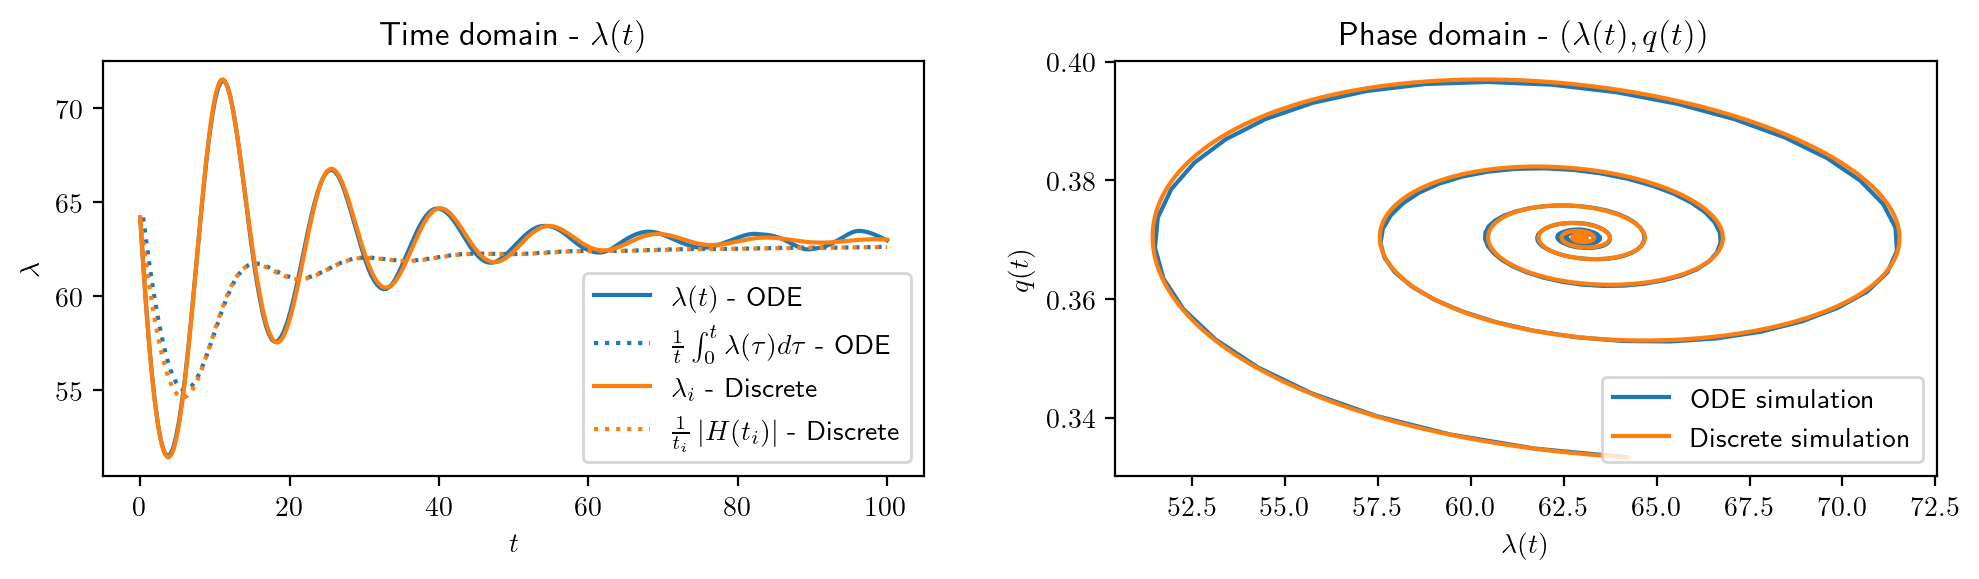

In [10]:

ode_res = lv.simulate_ode(ivp, myopic_recommender)
discrete_res = lv.simulate_discrete(ivp, myopic_recommender)

fig,ax = create_fig(1,2)
line = ax[0].plot(ode_res.t, ode_res.y[0], label=r'$\lambda(t)$ - ODE')
c = line[0].get_color()
ax[0].plot(*cum_avg(ode_res.t, ode_res.y[0]), ':', color=c, label=r'$\frac{1}{t}\int_0^t\lambda(\tau)d\tau$ - ODE')
line = ax[0].plot(discrete_res.events_df()['latent_state'].map(lambda t: t[0]), label=r'$\lambda_i$ - Discrete')
c = line[0].get_color()
ax[0].plot(discrete_res.events_df()['cumulative_rate'], ':', color=c, label=r'$\frac{1}{t_i}\left|H(t_i)\right|$ - Discrete')
ax[0].legend()
ax[0].set(
    title=r'Time domain - $\lambda(t)$',
    xlabel=r'$t$',
    ylabel=r'$\lambda$',
)


cum_avg = lambda t,x: (t[1:], np.cumsum(np.diff(t)*x[:-1])/t[1:])

ax[1].plot(*ode_res.y[:2], label='ODE simulation')
ax[1].plot(*discrete_res.events_df()['latent_state'].pipe(lambda s: np.array(s.tolist())).T[:2], label='Discrete simulation')
ax[1].legend()
ax[1].set(
    title=r'Phase domain - $(\lambda(t),q(t))$',
    xlabel=r'$\lambda(t)$',
    ylabel=r'$q(t)$',
)
fig.tight_layout(w_pad=4)


## Empirical simulation - Stochastic

In [11]:
lv = lvml.LotkaVolterraDynamicalSystem(
    alpha=1.5,
    beta=np.arange(5)+1,
    gamma=1e-1,
    delta=1e-3,
)

predicted_ratings=np.array([3.550361125816256, 3.8597579164878644, 3.9188785002650284, 3.952254436900264, 3.7323289431609035, 3.695879539767117, 4.225372563689326, 3.8585442522961375, 3.5972850743788833, 4.2605633549838835, 2.980885544209226, 3.3717896620506034, 3.191902701442402, 4.277655474011338, 4.370519754234184, 3.961151559999169, 3.90753957025024, 3.8967022305653303, 4.503076293595809, 4.012111602305471, 4.067141439914146, 3.9436914582872915, 3.811343813773409, 4.39614979755028, 4.035760151990023, 3.523465050096533, 3.7520600219635667, 3.845768035906705, 2.9198468492392067, 3.1368093678825772, 3.956548335248602, 3.4738394704160775, 3.8092559807999375, 3.8153075763594373, 4.311781005502261, 3.957921140712275, 3.4714008710662863, 3.219603244138496, 3.2825569110275685, 3.1545850282772805, 3.7853872427449433, 4.100312084605467, 4.022960855502739, 4.5214176537582365, 3.4196152056967484, 3.927105971699967, 3.5868656886674235, 3.9290999087088885, 3.781426465035388, 3.2593181384588035, 4.263754004194251, 3.338321546254274, 4.115374365205509, 3.71879531018862, 4.081441736846894, 3.838641814896115, 4.149564860583239, 3.386337020000275, 3.1043347705096154, 3.815283735803373, 3.9445448994421444, 3.94338593300773, 4.330473828698682, 3.329051060587971, 3.975747309653658, 3.8208651770374122, 3.232502041560569, 3.859151047303385, 4.285591067327205, 3.864660241432277, 3.379399416405687, 4.191187146292468, 3.2919808429331967, 4.1426812353661235, 3.3177894528661307, 3.5712316641079056, 3.3176439901051715, 3.642115334678205, 4.207286502640922, 4.344647288222194, 4.261959207195357, 4.342128203419927, 3.6727585420038604, 3.827898872208006, 4.032965386789573, 3.5327300942679964, 3.9028613148374567, 3.6443983823369295, 3.999460072030241, 3.9252096788529216, 3.3119539697294247, 3.9048474344788584, 3.6093995460465846, 3.8031476579271857, 3.668873002576288, 3.829485293377741, 3.7669692288779206, 3.6424760039998105, 3.7160891445312876, 3.435708360607382, 3.8502764913554666, 4.202346725979188, 3.8385895443384364, 3.9820417584630885, 4.063666956444078, 3.289354524344484, 3.8877323786695706, 4.4449641476433115, 3.3802178321875123, 3.5895297529886063, 4.108481489137391, 3.3311633823886324, 4.408858279221328])
true_ratings=np.array([3.0, 4.0, 4.0, 3.0, 5.0, 2.0, 5.0, 4.0, 4.0, 4.0, 2.0, 2.0, 2.0, 4.0, 4.0, 4.0, 4.0, 3.0, 4.0, 4.0, 4.0, 5.0, 3.0, 5.0, 4.0, 3.0, 4.0, 4.0, 2.0, 2.0, 4.0, 4.0, 4.0, 4.0, 5.0, 5.0, 4.0, 1.0, 4.0, 4.0, 4.0, 4.0, 4.0, 5.0, 2.0, 4.0, 2.0, 4.0, 5.0, 4.0, 3.0, 4.0, 4.0, 3.0, 4.0, 5.0, 4.0, 4.0, 4.0, 4.0, 5.0, 4.0, 4.0, 4.0, 5.0, 4.0, 2.0, 4.0, 4.0, 5.0, 3.0, 4.0, 2.0, 4.0, 3.0, 3.0, 4.0, 3.0, 4.0, 4.0, 5.0, 5.0, 5.0, 3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 3.0, 4.0, 5.0, 4.0, 3.0, 4.0, 4.0, 4.0, 2.0, 3.0, 5.0, 5.0, 5.0, 2.0, 4.0, 4.0, 4.0, 4.0, 5.0, 4.0, 2.0, 4.0, 5.0, 3.0])


In [12]:
rec = lvml.StationaryRecommender(
    p_fb=0.3,
    predicted_ratings=predicted_ratings,
    true_ratings=true_ratings,
    softmax_t=1,
)

ivp = lvml.IVP(
    y_0 = rec.equilibrium(lv)*(1+np.random.uniform(-1,1,size=2)*0.1),
    T = 100,
)

batch_size=1, empirical_rate=64.75
batch_size=10, empirical_rate=65.49


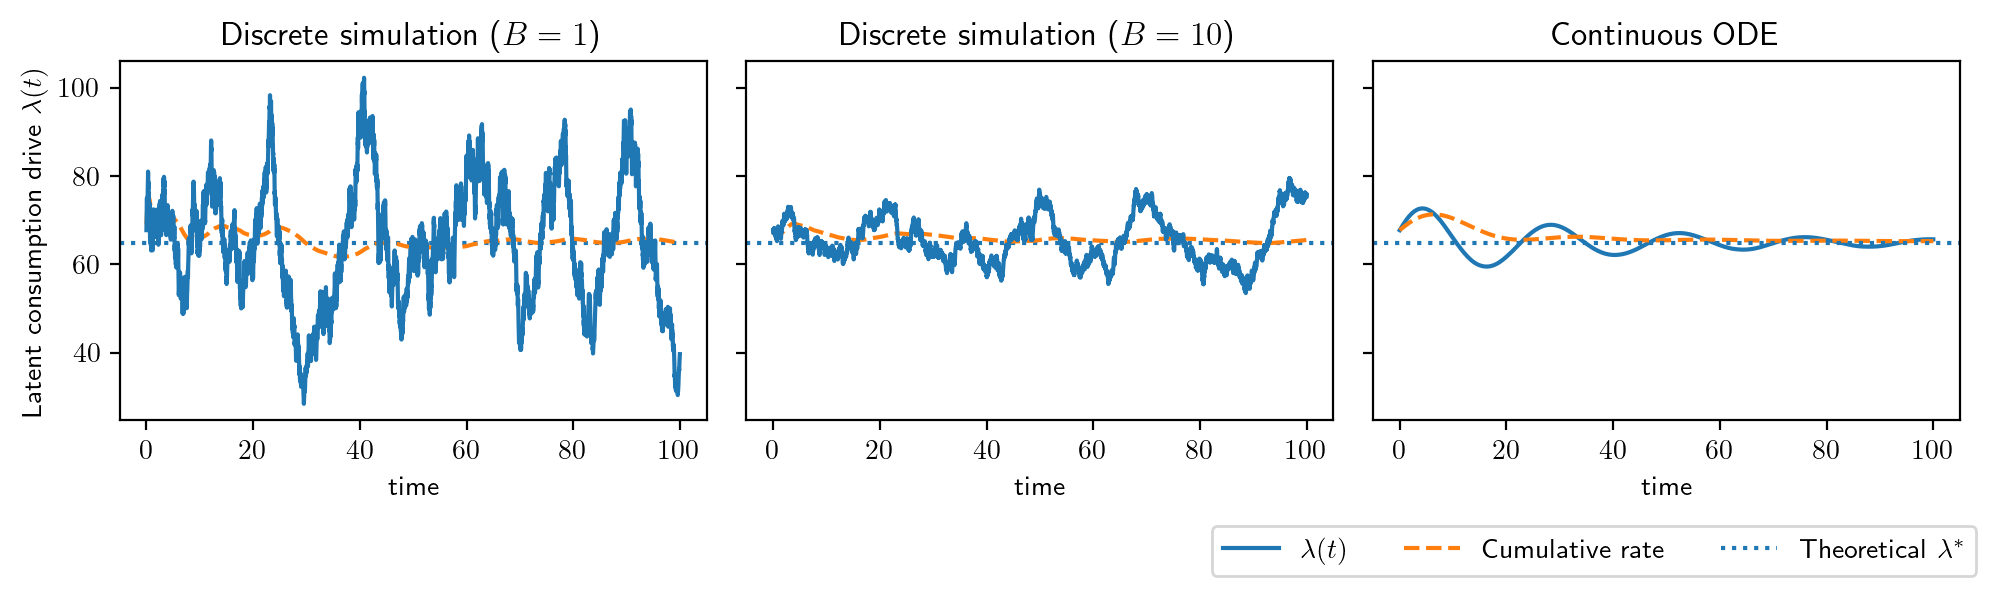

In [13]:
lvml.random_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

fig,axs=create_fig(1,3,sharex=True,sharey=True,tight_layout=dict(rect=(0,0.1,1,1)))

for batch_size,c,ax in zip([1,10], matplotlib.colors.TABLEAU_COLORS, axs):
    discrete_res = lv.simulate_discrete(ivp, rec, batch_size=batch_size)
    events_df = discrete_res.events_df()
    l = (
        events_df
        ['latent_state']
        .map(lambda arr: arr[0])
        .plot.line(
            ax=ax,
        )
    )
    (
        discrete_res.events_df()
        ['cumulative_rate']
        .plot.line(
            ax=ax,
            linestyle='--',
            zorder=-1,
        )
    )
    ax.axhline(
        rec.equilibrium(lv)[0],
        linestyle=':',
        label='Theoretical LV equilibrium',
        zorder=-2,
    )
    ax.set(
        xlabel='time',
        ylabel='Latent consumption drive $\lambda(t)$',
        title=f'Discrete simulation ($B={batch_size}$)',
    )
    print(f'batch_size={batch_size}, empirical_rate={discrete_res.empirical_rate():.2f}')

ode_res = lv.simulate_ode(ivp, rec, num_steps=ivp.T*3)
axs[2].plot(
    ode_res.t,
    ode_res.y[0],
    label='Corresponding ODE solution',
)
axs[2].plot(
    ode_res.t,
    ode_res.y[0].cumsum()/(1+np.arange(len(ode_res.t))),
    linestyle='--',
)
axs[2].axhline(
    rec.equilibrium(lv)[0],
    linestyle=':',
    label='Theoretical LV equilibrium',
)
axs[2].set(
    xlabel='time',
    ylabel='latent $\lambda(t)$',
    title=f'Continuous ODE',
)

fig.legend(
    l.get_lines(),
    [
        '$\lambda(t)$',
        r'Cumulative rate',
        'Theoretical $\lambda^*$',
    ],
    loc='lower right',
    bbox_to_anchor=(1,0),
    ncol=3,
    bbox_transform=fig.transFigure,
)

fig.download('discrete_and_continuous_lv_simulation.pdf')

## Safety policy

In [14]:
lv = lvml.LotkaVolterraDynamicalSystem(
    alpha=1.3,
    beta=(np.arange(5)+1)**2/5,
    gamma=2e-1,
    delta=1e-2,
)

myopic_rec = lvml.StationaryRecommender(
    p_fb=0.0,
    predicted_ratings=predicted_ratings,
    true_ratings=true_ratings,
    softmax_t=1,
)

ivp = lvml.IVP(
    y_0 = rec.equilibrium(lv)*(1+np.random.uniform(-1,1,size=2)*0.1),
    T = 100,
)

In [15]:
limit_params = lvml.RateLimitParams(
    lookback_n=10,
    rate_threshold=20,
    cooldown_period=1,
)
discrete_res = lv.simulate_discrete(
    ivp, 
    myopic_rec, 
    batch_size=10,
    rate_limit_params=limit_params,
)

In [16]:
threshold_vals=np.arange(15,25)
res_df = pd.DataFrame([
    {
        't': t,
        'rep': i,
        'res':lv.simulate_discrete(
            ivp, 
            myopic_rec, 
            batch_size=10,
            rate_limit_params=lvml.RateLimitParams(
                lookback_n=50,
                rate_threshold=t,
                cooldown_period=1,
            )
        )
    }
    for t in threshold_vals
    for i in range(10)
])

ref_res = lv.simulate_discrete(
    ivp, 
    myopic_rec, 
    batch_size=10,
)


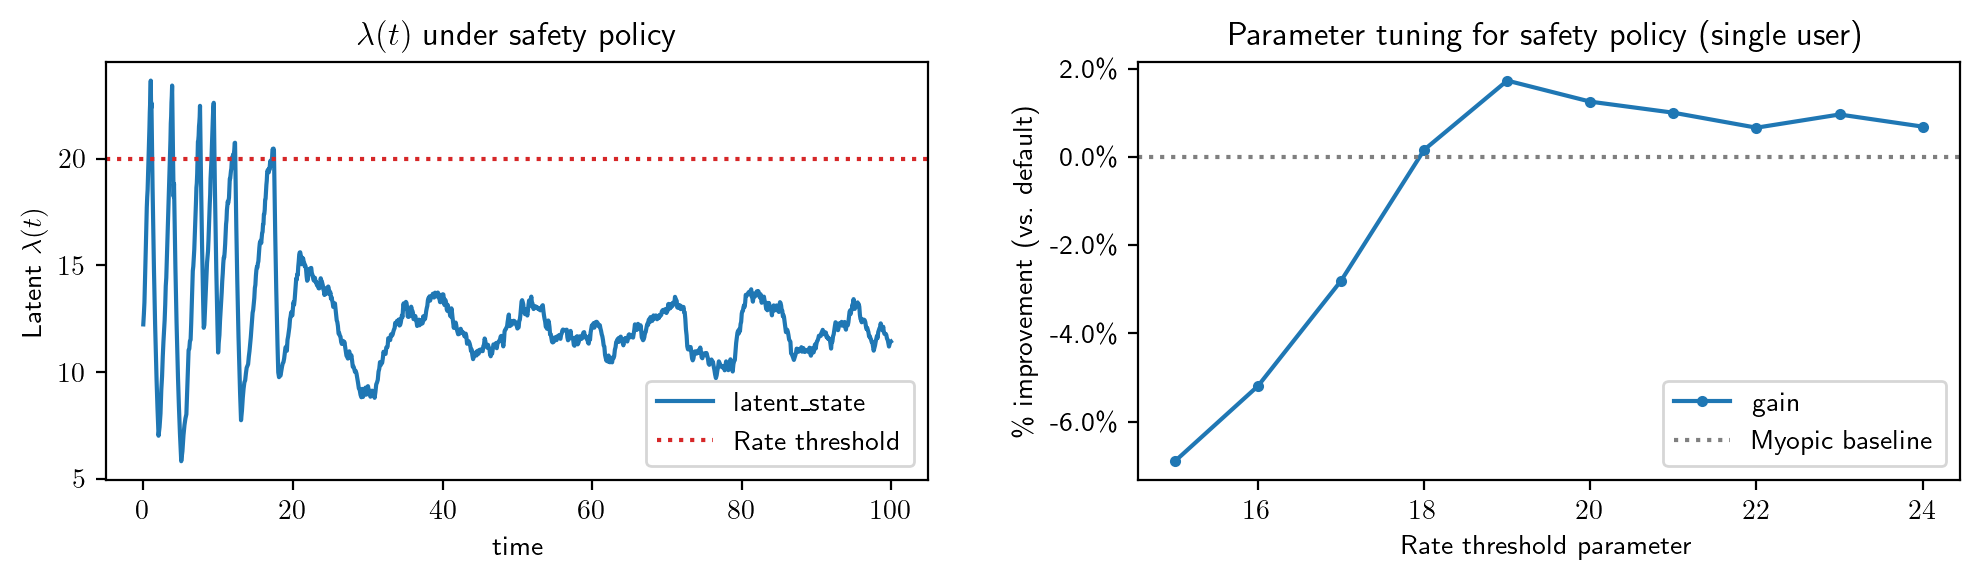

In [17]:
fig,axs=create_fig(1,2)

ax=axs[0]
discrete_res.events_df()['latent_state'].map(lambda t: t[0]).plot.line(ax=ax)
ax.axhline(limit_params.rate_threshold,label='Rate threshold', color='tab:red', linestyle=':')
ax.set(
    title='$\lambda(t)$ under safety policy',
    xlabel='time',
    ylabel='Latent $\lambda(t)$',
)

ax.legend()
ax=axs[1]
(
    res_df
    .assign(
        gain=lambda df: df['res'].map(lambda r: r.empirical_rate()/ref_res.empirical_rate()-1)
    )
    .groupby('t')
    ['gain']
    .mean()
    .plot.line(ax=ax, marker='.')
)
ax.set(
    ylabel='\% improvement (vs. default)',
    xlabel='Rate threshold parameter',
    title='Parameter tuning for safety policy (single user)',
)
ax.axhline(0,linestyle=':',label='Myopic baseline',color='tab:gray')
ax.legend()
ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x,pos: f'{round(x*100,1)}\%'))